In [5]:
import sys
import logging

# so = open("model_selection.log", 'w', 10)
# sys.stdout.echo = so
# sys.stderr.echo = so
# 
# get_ipython().log.handlers[0].stream = so
# get_ipython().log.setLevel(logging.INFO)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
folder_path = "../study"
stats_path = folder_path + "/stats"

In [8]:
# Reading the whole dataset
df = pd.read_csv("%s/dataset.csv" % stats_path, index_col="ID")
print(df.shape)
# # Removing the healty subjects
# df.dropna(axis=0, how="any", inplace=True) 
# print(df.shape)

info = df.columns[:10]
df[info] = df[info].astype(int)

df = df.drop("VNSLC_16") # remove it because doesn't have the tracts from freesurfer
df = df.dropna(axis=1) # remove NaN features
df = df.drop(df.filter(regex=r'(min|max)'), axis=1) # remove max and min features because are full of imperfections
df = df.drop(df.filter(regex=r'(kurt|nTracts)'), axis=1) # remove them beacuse they have an high variability and difficult to interpretare (only kurt)
print(df.shape)

(19, 11272)
(18, 5560)


In [8]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
seed = 9
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
sss = StratifiedShuffleSplit(n_splits=100, test_size=1/3, random_state=seed)
for train, test in sss.split(X, y):
    print(train, test)

print("")

seedOuter = 7
skfOuter = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
seedInner = 13
skfInner = StratifiedKFold(n_splits=4, shuffle=True, random_state=seed)
for trainOut, testOut in skfOuter.split(X, y):
    print(trainOut, testOut)
    for trainIn, testIn in skfInner.split(trainOut, y[trainOut]):
        print("\t", trainIn, testIn)

[15 11 12  6 10  2 14  8  0 13  3 17] [ 9 18  7  5  4 16  1]
[16  9 10 14  6  0 11  8  1 18  3  5] [ 4  7 17 12 15  2 13]
[11  9  3 13  1  6  4  7 14 10 12 18] [ 0  5 15  8  2 16 17]
[ 0 12  6  5  2  3 18 10  9 16 11 17] [14  4 13  1  7  8 15]
[ 6 13 12  5  2 14 16  4  3 18  7 11] [ 9 15  0  1  8 10 17]
[ 0  2  9 17  3  4  7  6 18  1 15  5] [11 14 10 16 12  8 13]
[15  8  7  0 13  1  3 16  4  9 14 12] [10  5 18 11 17  6  2]
[14  9 17  1  6 16 15 11  2 12  0  8] [10 18  7  5  4 13  3]
[17 11  5  3  1 15  4 10  0 12  2  6] [ 8 13 14 18 16  7  9]
[16  8 14  3  5  4  7  1 18 13  9  6] [12 11 17 10  2  0 15]
[ 1  9 17 18  5  4  0 15  2 13  7 12] [ 3 10 16  6 11 14  8]
[14  4  7  3 12  6 10  0  1  9  2 17] [ 8 18  5 16 13 15 11]
[12  7 18  1  8  4  9 15 13  6 17  5] [14 16  0 10  3 11  2]
[18 14  9  5 10 16  8  2 12  7 11 13] [15  3 17  6  1  0  4]
[ 0  1 10 13  6  8  4  5 15 12  7 14] [ 2  3 17 16 18 11  9]
[ 8 10 13  1  6  4 16 15  2  7  0 12] [ 3 18 17  5  9 14 11]
[ 6 18 16 11  1  2 10  3

# Feature Selection

## Filter Approach (Univariate)

The methods based on **F-test** estimate the degree of **linear dependency** between two random variables. On the other hand, **mutual information** methods can capture any kind of statistical dependency, but being nonparametric, they **require more samples** for accurate estimation.

### F-test

In [10]:
df_noNaN = df.dropna(axis=0, how="any")
X = df_noNaN.drop(["resp", "respPart", *col_disc], axis=1)
y = df_noNaN["resp"]

In [11]:
from sklearn.feature_selection import SelectPercentile, f_classif

sel = SelectPercentile(f_classif, percentile=1).fit(X,y)
scores = sel.scores_
scores /= scores.max()
scores = pd.DataFrame(scores, index=X.columns, columns=["score"]).sort_values("score", ascending=False)

n_sel = sel.get_support().sum()
print(scores[:n_sel])

X.columns[sel.get_support()]

                                          score
left-fornix_RD_mean                    1.000000
left-putamen_frac_csf_mf_std           0.998833
left-fornix_MD_mean                    0.831628
left-thalamus-proper_fextra_kurt       0.809705
left-thalamus-Insula_frac_c0_skew      0.793051
left-amygdala_RD_mean                  0.733409
right-thalamus-Insula_MD_mean          0.677405
right-thalamus-Insula_fintra_mean      0.658297
right-sup-longi-fasci_MD_kurt          0.647601
left-thalamus-proper_MD_std            0.641332
left-amygdala_MD_mean                  0.622954
left-putamen_frac_csf_mf_skew          0.621146
left-hippocampus_odi_kurt              0.594752
right-fornix_MD_mean                   0.592847
right-fornix_icvf_kurt                 0.588779
left-putamen_frac_csf_mf_kurt          0.585135
right-fornix_fintra_mean               0.582610
left-hippocampus_odi_std               0.568707
right-thalamus-Insula_frac_csf_d_mean  0.559797
left-putamen_AD_mean                   0

Index(['left-putamen_AD_mean', 'left-fornix_RD_mean', 'left-amygdala_RD_mean',
       'left-fornix_MD_mean', 'right-fornix_MD_mean',
       'right-sup-longi-fasci_MD_kurt', 'right-thalamus-Insula_MD_mean',
       'left-thalamus-proper_MD_std', 'left-amygdala_MD_mean',
       'right-fornix_icvf_kurt', 'left-thalamus-proper_icvf_kurt',
       'left-hippocampus_odi_std', 'left-hippocampus_odi_kurt',
       'left-thalamus-proper_fextra_kurt', 'right-fornix_fintra_mean',
       'right-thalamus-Insula_fintra_mean',
       'left-thalamus-Insula_frac_c0_skew',
       'right-thalamus-Insula_frac_csf_d_mean', 'left-putamen_frac_csf_mf_std',
       'left-putamen_frac_csf_mf_skew', 'left-putamen_frac_csf_mf_kurt'],
      dtype='object')

### Mutual Information

In [12]:
from sklearn.feature_selection import SelectPercentile, mutual_info_classif

sel = SelectPercentile(mutual_info_classif, percentile=1).fit(X, y)
scores = sel.scores_
scores /= scores.max()
scores = pd.DataFrame(scores, index=X.columns, columns=["score"]).sort_values("score", ascending=False)

n_sel = sel.get_support().sum()
print(scores[:n_sel])

X.columns[sel.get_support()]

                                      score
right-inf-longi-fasci_wFA_kurt     1.000000
right-amygdala_RD_skew             0.972744
right-accumbens-area_frac_c1_std   0.954349
right-fornix_icvf_std              0.889015
left-accumbens-area_fvf_f1_std     0.869267
right-fornix_odi_mean              0.868410
left-amygdala_AD_mean              0.866703
left-fornix_fvf_f1_skew            0.848296
right-pallidum_fvf_f1_mean         0.830012
left-inf-longi-fasci_FA_skew       0.820869
right-fornix_fvf_f1_std            0.817212
right-fornix_AD_std                0.808070
left-thalamus-Insula_frac_c0_skew  0.798261
left-putamen_odi_mean              0.791486
left-thalamus-Insula_AD_mean       0.777351
right-thalamus-Insula_MD_mean      0.774730
right-inf-longi-fasci_wAxD_mean    0.773694
left-fornix_FA_kurt                0.770037
right-sup-longi-fasci_icvf_kurt    0.768757
right-amygdala_frac_c0_skew        0.766014
right-amygdala_frac_f1_std         0.764982


Index(['left-inf-longi-fasci_FA_skew', 'left-fornix_FA_kurt',
       'right-fornix_AD_std', 'left-thalamus-Insula_AD_mean',
       'left-amygdala_AD_mean', 'right-amygdala_RD_skew',
       'right-thalamus-Insula_MD_mean', 'right-fornix_icvf_std',
       'right-sup-longi-fasci_icvf_kurt', 'right-fornix_odi_mean',
       'left-putamen_odi_mean', 'right-inf-longi-fasci_wFA_kurt',
       'right-inf-longi-fasci_wAxD_mean', 'left-thalamus-Insula_frac_c0_skew',
       'right-amygdala_frac_c0_skew', 'right-accumbens-area_frac_c1_std',
       'left-fornix_fvf_f1_skew', 'right-fornix_fvf_f1_std',
       'left-accumbens-area_fvf_f1_std', 'right-pallidum_fvf_f1_mean',
       'right-amygdala_frac_f1_std'],
      dtype='object')

### Mixed Metodology: Mutual Information + F-Score

We take in account both scores, and weight them as 0.5 each

In [15]:
from sklearn.feature_selection import SelectPercentile, mutual_info_classif, f_classif

def myScoreFunc(X, y):
    mi_score = mutual_info_classif(X, y)
    f_score = f_classif(X, y)[0]
    return mi_score + f_score

sel = SelectPercentile(myScoreFunc, percentile=1).fit(X, y) # Percentile could be an hyperparameter from 10 to 50
scores = sel.scores_
scores /= scores.max()
scores = pd.DataFrame(scores, index=X.columns, columns=["score"]).sort_values("score", ascending=False)

n_sel = sel.get_support().sum()
print(scores[:n_sel])

X.columns[sel.get_support()]

                                          score
left-putamen_frac_csf_mf_std           1.000000
left-fornix_RD_mean                    0.995628
left-fornix_MD_mean                    0.834182
left-thalamus-proper_fextra_kurt       0.806653
left-thalamus-Insula_frac_c0_skew      0.799024
left-amygdala_RD_mean                  0.739018
right-thalamus-Insula_MD_mean          0.684055
right-thalamus-Insula_fintra_mean      0.664546
left-thalamus-proper_MD_std            0.641837
right-sup-longi-fasci_MD_kurt          0.636104
left-amygdala_MD_mean                  0.628384
left-putamen_frac_csf_mf_skew          0.622948
right-fornix_MD_mean                   0.599293
left-hippocampus_odi_kurt              0.594043
right-fornix_icvf_kurt                 0.592384
right-fornix_fintra_mean               0.583677
left-putamen_frac_csf_mf_kurt          0.582018
left-hippocampus_odi_std               0.574172
left-putamen_AD_mean                   0.565323
right-thalamus-Insula_frac_csf_d_mean  0

Index(['left-putamen_AD_mean', 'left-fornix_RD_mean', 'left-amygdala_RD_mean',
       'left-fornix_MD_mean', 'right-fornix_MD_mean',
       'right-sup-longi-fasci_MD_kurt', 'right-thalamus-Insula_MD_mean',
       'left-thalamus-proper_MD_std', 'left-amygdala_MD_mean',
       'right-fornix_icvf_kurt', 'left-thalamus-proper_icvf_kurt',
       'left-hippocampus_odi_std', 'left-hippocampus_odi_kurt',
       'left-thalamus-proper_fextra_kurt', 'right-fornix_fintra_mean',
       'right-thalamus-Insula_fintra_mean',
       'left-thalamus-Insula_frac_c0_skew',
       'right-thalamus-Insula_frac_csf_d_mean', 'left-putamen_frac_csf_mf_std',
       'left-putamen_frac_csf_mf_skew', 'left-putamen_frac_csf_mf_kurt'],
      dtype='object')

## Weapper methods

### Forward selection

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import svm

sfs = SequentialFeatureSelector(
    estimator = clf_dual, 
    n_features_to_select=10,
    direction="forward",
    scoring="roc_auc",
    cv=skf,
    n_jobs=-1,
    )

sfs.fit(X, y)
X.columns[sfs.get_support()].sort_values()

# Building a model

In [6]:
from sklearn.feature_selection import f_classif, mutual_info_classif

def myScoreFunc(X, y):
    mi_score = mutual_info_classif(X, y)
    f_score = f_classif(X, y)[0]
    return mi_score + f_score

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split

class ROC_DET_plot():

    def __init__(self) -> None:
        fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))
        self.ax_roc = ax_roc
        self.ax_det = ax_det

    def add2print_ROC_DET(self, estimator, X, y, name):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

        estimator.fit(X_train, y_train)

        RocCurveDisplay.from_estimator(estimator, X_test, y_test, ax=self.ax_roc, name=name)
        DetCurveDisplay.from_estimator(estimator, X_test, y_test, ax=self.ax_det, name=name)

    def printAll_ROC_DET(self):
        self.ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
        self.ax_det.set_title("Detection Error Tradeoff (DET) curves")

        self.ax_roc.grid(linestyle="--")
        self.ax_det.grid(linestyle="--")

        plt.legend()
        plt.show()


In [8]:
from sklearn.model_selection import GridSearchCV, cross_val_score

def estimate_score_GridNestedCV(estimator, X, y, hyperPars, cvOuter, cvInner, fig:ROC_DET_plot, name:str):
    # Inner Cross-Validation for Hyper-parameters selection
    model = GridSearchCV(
        estimator=estimator,
        param_grid=hyperPars,
        scoring="roc_auc",
        n_jobs=-1,
        cv=cvInner,
        refit=True
    )

    # Outer Cross-Validaton for the estimation of the score
    scores = cross_val_score(
        model, X, y,
        scoring="roc_auc",
        cv=cvOuter,
        n_jobs=-1
    )

    fig.add2print_ROC_DET(model, X, y, name)
    print('ROC-AUC: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
    print("----------------------------")

def estimate_score_NestedCV(estimator, X, y, cvOuter, fig:ROC_DET_plot, name:str):
    # Inner Cross-Validation for Hyper-parameters selection already done in the estimator

    # Outer Cross-Validaton for the estimation of the score
    scores = cross_val_score(
        estimator, X, y,
        scoring="roc_auc",
        cv=cvOuter,
        n_jobs=-1
    )

    fig.add2print_ROC_DET(estimator, X, y, name)
    print('ROC-AUC: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
    print("----------------------------")

## Histogram-based Gradient Boosting Classification Tree

This is a classififier similar to the **Gradient Boosting Classifier**, but it can work also with features that have NaN values. The implementation is based on [LightGBM](https://github.com/Microsoft/LightGBM). It's much faster than the normal implementation of the radient Boosting.

For binary classification is used a ```log_loss``` as loss for classification.
The number of bins is controlled by ```max_bins```. Using less bins acts as a form of regularization. It is generally reccomended to use as many bins as possible, which is the default.
The ```l2_regularization``` is a regulariazion term, and correspond to $\lambda$.
The easrly-stopping is controlled by ```early_stopping```, ```scoring```, ```validation_fraction```, ```n_iter_no_change```, and ```tol```. 

The algorithm has native support for categorical features. To enable this support, a boolean mask can be passed to ```categorical_feature```, indicating which feature is categorical. Or, one can pass a list of integers indicating the indices of the categorical features.

Can be declared some constraints to speed-up the algorithm: *Monotonic Constraint*, and *Interaction constraint*.

Scaler: StandardScaler , filter: No
ROC-AUC: 0.500 (0.000)
----------------------------
Scaler: RobustScaler , filter: No
ROC-AUC: 0.500 (0.000)
----------------------------


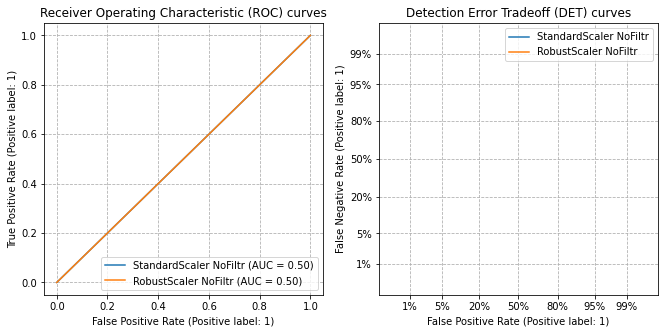

In [9]:
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.feature_selection import  VarianceThreshold, SequentialFeatureSelector, RFECV, SelectFromModel
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

hyperPars = {
    "hist__learning_rate" : [0.01, 0.1],
    "hist__max_iter" : [50, 100, 200],
    "hist__max_depth" : [8, 16],
    "hist__l2_regularization" : [0.01, 0.1],
}

fig = ROC_DET_plot()

# Without feature Selection
for scaler in [StandardScaler(), RobustScaler()]:
    print("Scaler:", scaler.__class__.__name__, ", filter: No")
    name = str(scaler.__class__.__name__+" NoFiltr")

    # Scaling
    pre = ColumnTransformer(
        [("scaling", scaler, col_cont)],
        remainder="passthrough", # one hot or other stuff
        n_jobs=-1
    )

    mask_cat = np.array([False,]*X.shape[1])
    mask_cat[-4:] = True
    hist = HistGradientBoostingClassifier(
        categorical_features = mask_cat
    )

    # Pipe
    pipe = Pipeline([
        ("pre", pre),
        ("hist", hist)
    ])

    estimate_score_GridNestedCV(pipe, X, y, hyperPars, skfOuter, skfInner, fig, name)

fig.printAll_ROC_DET()

## Removing NaN samples

Since the Histogram-Based Gradient Boosting is the only model given in scikit learn that support NaN values, now we remove the nan samples to estimate the performance of the other models.

In [10]:
df_noNaN = df.dropna(axis=0, how="any")
X = df_noNaN.drop(["resp", "respPart"], axis=1)
y = df_noNaN["resp"]

print("X:", X.shape)
print("y:", y.shape)

X: (16, 2042)
y: (16,)


In [11]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
seed = 9
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
sss = StratifiedShuffleSplit(n_splits=5, test_size=1/5, random_state=seed)
for train, test in skf.split(X, y):
    print(train, test)

print("")

seedOuter = 7
skfOuter = StratifiedKFold(n_splits=4, shuffle=True, random_state=seed)
seedInner = 13
skfInner = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
for trainOut, testOut in skfOuter.split(X, y):
    print(trainOut, testOut)
    for trainIn, testIn in skfInner.split(trainOut, y[trainOut]):
        print("\t", trainIn, testIn)

[ 0  1  3  6  7  9 10 11 12 14] [ 2  4  5  8 13 15]
[ 2  3  4  5  6  7  8  9 10 13 15] [ 0  1 11 12 14]
[ 0  1  2  4  5  8 11 12 13 14 15] [ 3  6  7  9 10]

[ 0  1  3  6  7  8  9 10 11 12 13 14] [ 2  4  5 15]
	 [ 0  2  4  7  8  9 10 11] [1 3 5 6]
	 [ 0  1  2  3  5  6  9 10] [ 4  7  8 11]
	 [ 1  3  4  5  6  7  8 11] [ 0  2  9 10]
[ 0  2  3  4  5  6  7  9 10 11 14 15] [ 1  8 12 13]
	 [ 0  2  4  6  8  9 10 11] [1 3 5 7]
	 [ 0  1  2  3  5  7  9 10] [ 4  6  8 11]
	 [ 1  3  4  5  6  7  8 11] [ 0  2  9 10]
[ 1  2  3  4  5  6  7  8  9 12 13 15] [ 0 10 11 14]
	 [ 0  2  4  6  7  9 10 11] [1 3 5 8]
	 [ 0  1  2  3  5  8  9 10] [ 4  6  7 11]
	 [ 1  3  4  5  6  7  8 11] [ 0  2  9 10]
[ 0  1  2  4  5  8 10 11 12 13 14 15] [3 6 7 9]
	 [ 0  1  2  5  7  8  9 10] [ 3  4  6 11]
	 [ 0  2  3  4  6  7 10 11] [1 5 8 9]
	 [ 1  3  4  5  6  8  9 11] [ 0  2  7 10]


## Linear Regression with ElasticNet
### Elastic Net

Elastic Net is a **Linear Regression regularized** by the terms **L1** and **L2**. It's an hybrid form of the **Ridge Regression** and the **Lasso**.
The weight of these 2 different model is parametrized by ```l1_ratio```. If ```l1_ratio = 0``` the penalty is an L2 penalty(Ridge). If ```l1_ratio = 1``` the penalty is an L1 penalty (Lasso).

Since the Elastic Net implementation in skit learn works only for regression problems. We use the **Ridge Classifier**
### Ridge Classifier

It is like the **Ridge Regression**, the regularization strenght can be adjusted by the parameter ```aplha```. It corresponds to ```alpha = 1/(2C)```, in models like **Logistic Regression** or **SVM**. Regularization improves the conditioning of the problem and reduces the variance of the estimates. Larger values specify stronger regularization.

Scaler: StandardScaler , filter: No
ROC-AUC: 0.646 (0.355)
----------------------------
Scaler: RobustScaler , filter: No
ROC-AUC: 0.333 (0.333)
----------------------------
Scaler: StandardScaler , filter: f_classif
ROC-AUC: 0.375 (0.247)
----------------------------
Scaler: StandardScaler , filter: mutual_info_classif


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x2ae59ae650d0>
Traceback (most recent call last):
  File "/opt/cecisw/arch/easybuild/2021b/software/Python/3.9.6-GCCcore-11.2.0/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback


KeyboardInterrupt: 

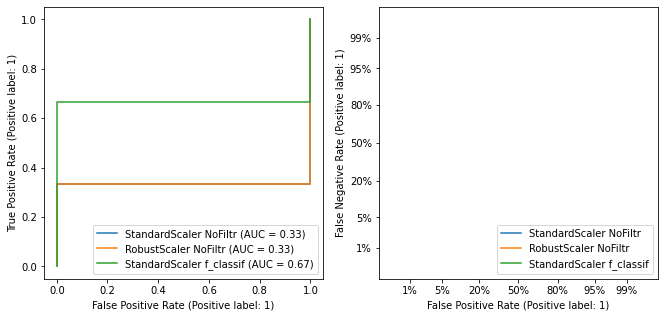

In [12]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.feature_selection import SelectKBest

fig = ROC_DET_plot()

######################################
# Remove Constant feautures
varThres = VarianceThreshold()

# Classifier
clf = RidgeClassifierCV(
    alphas=(0.01, 0.1, 1, 10, 100), # 0 == Linear Regressio
    scoring="roc_auc",
    cv=skfInner,
)

#######################################

# Without feature Selection
for scaler in [StandardScaler(), RobustScaler()]:
    print("Scaler:", scaler.__class__.__name__, ", filter: No")
    name = str(scaler.__class__.__name__+" NoFiltr")

    # Scaling
    pre = ColumnTransformer(
        [("scaling", scaler, col_cont)],
        remainder="passthrough", # one hot or other stuff
    )

    # Pipe
    pipe = Pipeline([
        ("pre", pre),
        ("varThs", varThres),
        ("clf", clf)
    ])

    estimate_score_NestedCV(pipe, X, y, skfOuter, fig, name)

# Filtering method
for scaler in [StandardScaler(), RobustScaler()]:
    for filter in [f_classif, mutual_info_classif, myScoreFunc]:
        print("Scaler:", scaler.__class__.__name__, ", filter:", filter.__name__)
        name = str(scaler.__class__.__name__+" "+filter.__name__)

        # Scaling
        pre = ColumnTransformer(
            [("scaling", scaler, col_cont)],
            remainder="passthrough", # one hot or other stuff
        )

        # Feature Selection
        selection = SelectKBest(
            score_func=filter
        )

        # Pipe
        pipe = Pipeline([
            ("pre", pre),
            ("varThs", varThres),
            ("selection", selection),
            ("clf", clf)
        ])

        estimate_score_NestedCV(pipe, X, y, skfOuter, fig, name)

# Forward method 
for scaler in [StandardScaler(), RobustScaler()]:
    print("Scaler:", scaler.__class__.__name__, ", filter: Forward")
    name = str(scaler.__class__.__name__+" Forward")

    # Scaling
    pre = ColumnTransformer(
            [("scaling", scaler, col_cont)],
            remainder="passthrough", # one hot or other stuff
        )

    # Feature Selection
    selection = SequentialFeatureSelector(
        estimator = ExtraTreesClassifier(random_state=0), 
        direction="forward",
        scoring="roc_auc",
        n_features_to_select=10,
        cv=skf,
    )

    # Pipe
    pipe = Pipeline([
        ("pre", pre),
        ("varThres", varThres),
        ("selection", selection),
        ("clf", clf)
    ])

    estimate_score_NestedCV(pipe, X, y, skfOuter, fig, name)

# Recoursive method 
for scaler in [StandardScaler(), RobustScaler()]:
    print("Scaler:", scaler.__class__.__name__, ", filter: Recoursive")
    name = str(scaler.__class__.__name__+" Recoursive")

    # Scaling
    pre = ColumnTransformer(
            [("scaling", scaler, col_cont)],
            remainder="passthrough", # one hot or other stuff
        )
    
    # Feature Selection
    selection = RFECV(
        estimator=ExtraTreesClassifier(random_state=0),
        step=1,
        scoring="roc_auc",
        cv=skf,
        min_features_to_select=2,
    )

    # Pipe
    pipe = Pipeline([
        ("pre", pre),
        ("varThres", varThres),
        ("selection", selection),
        ("clf", clf)
    ])

    estimate_score_NestedCV(pipe, X, y, skfOuter, fig, name)

# Embedded
for scaler in [StandardScaler(), RobustScaler()]:
    print("Scaler:", scaler.__class__.__name__, ", filter: Embedded")
    name = str(scaler.__class__.__name__+" Embedded")

    # Scaling
    pre = ColumnTransformer(
            [("scaling", scaler, col_cont)],
            remainder="passthrough", # one hot or other stuff
        )

    # Feature Selection
    selection = SelectFromModel(
        estimator=ExtraTreesClassifier(random_state=0),
        max_features=10,
    )

    # Pipe
    pipe = Pipeline([
        ("pre", pre),
        ("varThres", varThres),
        ("selection", selection),
        ("clf", clf)
    ])

    estimate_score_NestedCV(pipe, X, y, skfOuter, fig, name)

fig.printAll_ROC_DET()

In [22]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression, ElasticNet, LinearRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_auc_score

def myScoreFunc(X, y):
    mi_score = mutual_info_classif(X, y)
    f_score = f_classif(X, y)[0]
    return mi_score + f_score

models = {
    # SVM
    "linearSVM" : (
        LinearSVC(), 
        {
            "selection__k" : (2, 3, 5, 7, 9, 11, 13, 17, 19),
            "classifier__C" : (1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1),
        }
    ),
    "SVM" : (
        SVC(),
        [
            {
                "selection__k" : (2, 3, 5, 7, 9, 11, 13, 17, 19),
                "classifier__C" :(1e-3, 1e-2, 1e-1, 1),
                "classifier__kernel" : ['linear'], 
            },
            {
                "selection__k" : (2, 3, 5, 7, 9, 11, 13, 17, 19),
                "classifier__C" :(1e-3, 1e-2, 1e-1, 1),
                "classifier__kernel" : ['poly'],
                "classifier__degree" : (2, 3, 4),
            },
            {
                "selection__k" : (2, 3, 5, 7, 9, 11, 13, 17, 19),
                "classifier__C" :(1e-3, 1e-2, 1e-1, 1),
                "classifier__kernel" : ['rbf'], 
                "classifier__gamma" : (1e-3, 1e-2, 1e-1, 1),
            },
        ]
    ),
    # Linear 
    "LogReg" : (
        LogisticRegression(),
        {
            "selection__k" : (2, 3, 5, 7, 9, 11, 13, 17, 19),
            "classifier__penalty" : ["l2"],
            "classifier__dual" : [True],
            "classifier__C" :(1e-3, 1e-2, 1e-1),
        },
    ),
    "LinReg" : (
        LinearRegression(),
        {
            "selection__k" : (2, 3, 5, 7, 9, 11, 13, 17, 19),
        }
    ),
    "ridgeReg" : (
        RidgeClassifier(),
        {
            "selection__k" : (2, 3, 5, 7, 9, 11, 13),
            "classifier__alpha" : (0.5, 1, 5, 10, 20, 40)
        }
    ),
    "elasticNet" : (
        ElasticNet(),
        {
            "selection__k" : (2, 3, 5, 7, 9, 11, 13),
            "classifier__alpha" : (0.5, 1, 10),  # 0 == Linear Regression
            "classifier__l1_ratio" : (0.01, 0.5, 1), # 0 == Ridge Regression, 1 == Lasso Regression
        },
    ),
    # Nearest Neighbors
    "neighbors" : (
        KNeighborsClassifier(),
        {
            "selection__k" : (2, 3, 5, 7, 9, 11, 13),
            "classifier__n_neighbors" : (2, 3, 5),
            "classifier__weights" : ("uniform", "distance"),
        }
    ),
    # Naive Bayes
    "gaussianNaive" : (
        GaussianNB(),
        {
            "selection__k" : (2, 3, 5, 7, 9, 11, 13),
        }
    ),
    "multinomialNaive" : (
        MultinomialNB(),
        {
            "selection__k" : (2, 3, 5, 7, 9, 11, 13),
        }
    ),
    "complementNaive" : (
        ComplementNB(),
        {
            "selection__k" : (2, 3, 5, 7, 9, 11, 13),
        }
    ),
    "bernulliNaive" : (
        BernoulliNB(),
        {
            "selection__k" : (2, 3, 5, 7, 9, 11, 13),
        }
    ),
    "categoricalNaive" : (
        CategoricalNB(),
        {
            "selection__k" : (2, 3, 5, 7, 9, 11, 13),
        }
    ),
    # Tree
    "tree" : (
        DecisionTreeClassifier(),
        {
            "selection__k" : (2, 3, 5, 7, 9, 11, 13),
            "classifier__criterion" : ("gini", "entropy", "log_loss")
            # ccp_apha is a Regularization therm (to try)
        }
    ),
    # Ensemble
    "forest" : (
        RandomForestClassifier(),
        {
            "selection__k" : (2, 3, 5, 7, 9, 11, 13),
            "classifier__n_estimators" : (100, 500, 1000),
            # Check if make sense choose also the criterion (see the tree)
            "classifier__bootstrap" : [True],
            "classifier__max_samples" : [0.5],
            "classifier__max_features" : ["log2"],
            "classifier__warm_star" : [True],
            "classifier__oob_score" : [True],
            "classifier__max_depth" : [10, 20, 30],
            # ccp_alpha da checkare
        }
    ),
    "extraForest" : (
        ExtraTreesClassifier(),
        {
            "selection__k" : (2, 3, 5, 7, 9, 11, 13),
            "classifier__n_estimators" : (100, 500, 1000),
            # Check if make sense choose also the criterion (see the tree)
            "classifier__bootstrap" : [True],
            "classifier__max_samples" : [0.5],
            "classifier__max_features" : ["log2"],
            "classifier__warm_star" : [True],
            "classifier__oob_score" : [True],
            "classifier__max_depth" : [10, 20, 30],
            # ccp_alpha da checkare
        }
    ),
    "gradientBoosting": (
        GradientBoostingClassifier(),
        {
            "selection__k" : (2, 3, 5, 7, 9, 11, 13),
            "classifier__n_estimators" : (100, 200, 500, 1000),
            "classifier__learning_rate" : (0.05, 0.1),
            # Check if make sense choose also the criterion (see the tree)
            "classifier__max_samples" : [0.5],
            "classifier__max_features" : ["log2"],
            "classifier__warm_star" : [True],
            "classifier__max_depth" : [10, 20, 30],
            "classifier__validation_fraction" : [0.20],
            "classifier__n_iter_no_change" : [50],
            # ccp_alpha da checkare
        }
    )
}

# It's important to evaluate each algorithm with the same training data e test data
seed = 7
sss = StratifiedShuffleSplit(n_splits=20, test_size=1/3, random_state=seed)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

fitted_models = {}

for modelName, (classifier, grid) in models.items():
    for scaler in [StandardScaler(), RobustScaler()]:
        for filter in [f_classif, mutual_info_classif, myScoreFunc]:
            print("modelName:", modelName, ", scaler:", scaler.__class__.__name__, ", filter:", filter.__name__)

            # Scaling
            pre = ColumnTransformer(
                    [("scaling", scaler, col_cont)],
                    remainder="passthrough", # one hot or other stuff
                    n_jobs=-1
                )
            
            # Remove costant values
            # Yes, it's possible, since we have few data after the splitting and the cross validation is possible to have some features with same values. To remove them from the modeling we use the 
            varThres = VarianceThreshold()

            # Feature Selection
            selection = SelectKBest(
                    score_func=filter,
                )

            # Pipe
            pipe = Pipeline([
                ("pre", pre),
                ("varThres", varThres),
                ("selection", selection),
                ("classifier", classifier)
            ])

            model = GridSearchCV(
                estimator=pipe,
                param_grid=grid,
                scoring="roc_auc",
                n_jobs=-1,
                cv=skf,
            )

            model.fit(X_train, y_train)
            fitted_models[modelName] = model

            # Train
            print(modelName, "train score:", model.best_score_)
            print(model.best_params_) 

            idx = [param.__str__() for param in model.cv_results_["params"]]
            results = pd.DataFrame(pd.concat([pd.DataFrame(model.cv_results_["mean_test_score"], index=idx, columns=["mean_test_score"]), pd.DataFrame(model.cv_results_["std_test_score"], index=idx, columns=["std_test_score"]), pd.DataFrame(model.cv_results_["rank_test_score"], index=idx, columns=["rank_test_score"])], axis=1))
            print(results.sort_values("rank_test_score")[:10])

            # Test
            y_pred = model.predict(X_test)
            confusionMatrix = confusion_matrix(y_test, y_pred)  
            print(confusionMatrix)  
            print("Balanced Accuracy Score", balanced_accuracy_score(y_test, y_pred))
            print("Area Under ROC", roc_auc_score(y_test, y_pred,))


modelName: linearSVM , scaler: StandardScaler , filter: f_classif
linearSVM train score: 0.8333333333333334
{'classifier__C': 1e-06, 'selection__k': 17}
                                               mean_test_score   
{'classifier__C': 0.0001, 'selection__k': 19}         0.833333  \
{'classifier__C': 0.0001, 'selection__k': 17}         0.833333   
{'classifier__C': 0.001, 'selection__k': 17}          0.833333   
{'classifier__C': 1e-06, 'selection__k': 17}          0.833333   
{'classifier__C': 1e-06, 'selection__k': 19}          0.833333   
{'classifier__C': 0.001, 'selection__k': 19}          0.833333   
{'classifier__C': 0.01, 'selection__k': 19}           0.833333   
{'classifier__C': 0.01, 'selection__k': 17}           0.833333   
{'classifier__C': 1e-05, 'selection__k': 19}          0.833333   
{'classifier__C': 1e-05, 'selection__k': 17}          0.833333   

                                               std_test_score  rank_test_score  
{'classifier__C': 0.0001, 'selection__k

KeyboardInterrupt: 